In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
compression_model_id = "j1v1wv6w"
n_timesteps = 500

# Choose reference protein

In [3]:
import warnings
warnings.filterwarnings('ignore')

cath_id = "1jzdC00"
pdb_path = f"/data/lux70/data/cath/dompdb/{cath_id}"

from plaid.utils import parse_sequence_from_structure

with open(pdb_path) as f:
    pdb_str = f.read()
    
sequence = parse_sequence_from_structure(pdb_str, cath_id)
print(len(sequence))
print(sequence)

from plaid.utils import view_py3Dmol
view_py3Dmol(pdb_str)

118
RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCYPPETKTVPLSEVVAN


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Get embedding 

In [5]:
# from cheap.pretrained import CHEAP_pfam_shorten_2_dim_32
# cheap_pipeline = CHEAP_pfam_shorten_2_dim_32()

# import torch
# device = torch.device("cuda")
# cheap_pipeline.to(device)


In [ ]:
from cheap.proteins import LatentToSequence, LatentToStructure

latent_to_sequence = LatentToSequence()
latent_to_sequence.to(device)

latent_to_structure = LatentToStructure()
latent_to_structure.to(device)

from cheap.utils import LatentScaler
scaler = LatentScaler()

In [ ]:
emb, mask = cheap_pipeline([sequence])

In [ ]:
emb.shape

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(emb.squeeze().cpu().numpy())

# Diffusion Functions

In [6]:
from plaid.diffusion import FunctionOrganismDiffusion

diffusion = FunctionOrganismDiffusion(
    model=None,
    ema_decay=None,
    beta_scheduler_name="sigmoid",
    beta_scheduler_start=-3,
    beta_scheduler_end=3,
    beta_scheduler_tau=1,
    sampling_timesteps=n_timesteps,
    timesteps=n_timesteps
)

Text(0.5, 1.0, 'Log-SNR')

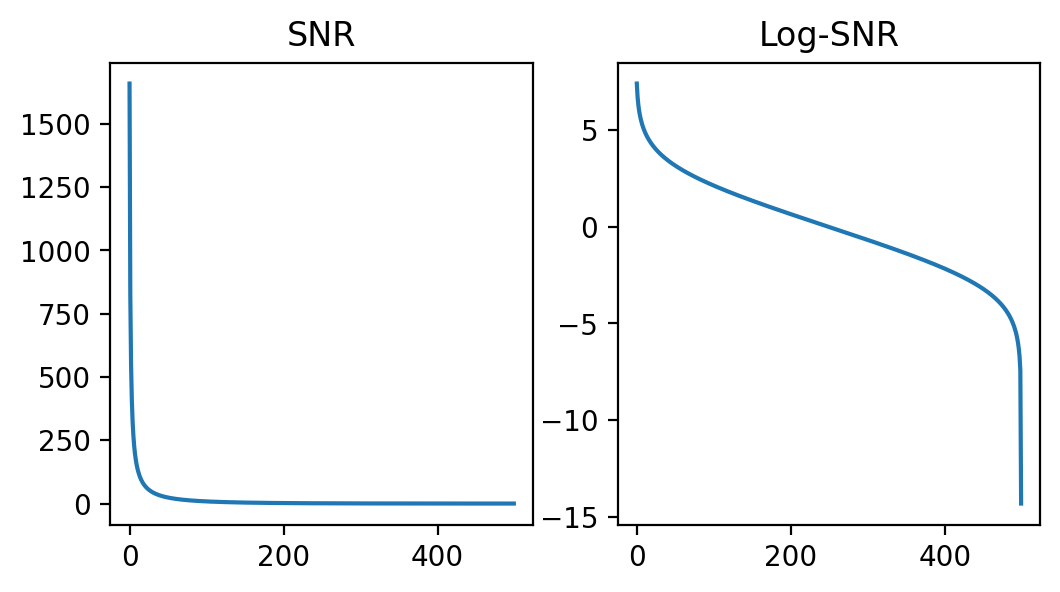

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2, figsize=(6,3),dpi=200)
axs[0].plot(diffusion.snr.numpy())
axs[0].set_title("SNR")
axs[1].plot(np.log(diffusion.snr.numpy()))
axs[1].set_title("Log-SNR")

# Noise Analysis

In [ ]:
x_start = emb

import einops

noise = torch.randn_like(x_start)
x_start = einops.repeat(x_start, "1 l c -> t l c", t=n_timesteps) 
noise = einops.repeat(noise, "1 l c -> t l c", t=n_timesteps) 
sequences = [sequence] * n_timesteps
t = torch.arange(n_timesteps).to(device)

In [ ]:
x_start, t, noise, diffusion = tuple(map(lambda x: x.to(device), (x_start, t, noise, diffusion)))
sample = diffusion.q_sample(x_start, t, noise)

In [ ]:
uncompressed = cheap_pipeline.hourglass_model.decode(sample)

In [ ]:
print(sample.shape, x_start.shape, uncompressed.shape)

In [ ]:
from cheap.utils import LatentScaler

latent_scaler = LatentScaler()
noised = latent_scaler.unscale(uncompressed)

In [ ]:
# from plaid.diffusion.beta_schedulers import make_beta_scheduler
# from plaid.evaluation import run_tmalign
# from plaid.utils import npy, calc_sequence_recovery
# import pickle as pkl
# from pathlib import Path
# import einops
# import numpy as np

# outdir = Path("/homefs/home/lux70/toy_sigmoid")
# outdir.mkdir()

# # noised sequences
# noised_sequences = latent_to_sequence.to_sequence(noised)[-1]
# print(len(noised_sequences))
# for i, s in enumerate(noised_sequences):
#     if i % 10 == 0:
#         print(s)

# with open(outdir/ "noised_sequences.fasta", "w") as f:
#     for seq in noised_sequences:
#         f.write(f"{seq}\n")

# seq_recovs = [calc_sequence_recovery(orig, noised) for orig, noised in zip(sequences, noised_sequences)]
# pkl.dump(seq_recovs, open(outdir / "sequence_recovery.pkl", "wb"))


# # noised structures
# res = latent_to_structure.to_structure(noised, sequences, batch_size=64)
# tm_scores = []

# for i, pdbstr in enumerate(res):
#     fname = outdir / f"noised_{i}.pdb"
#     with open(fname, "w") as f:
#         f.write(pdbstr)
#     tm_scores.append(run_tmalign(pdb_path, fname))
    
# pkl.dump(tm_scores, open(outdir / "tmscores.pkl", "wb"))


# # plot
# font = {'family' : 'sans',
#     'weight' : 'normal',
#     'size'   : 14}

# import matplotlib
# matplotlib.rc('font', **font)

# fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=120)

# axs[0].plot(seq_recovs)
# axs[0].set_title("Sequence Recovery")
# axs[0].set_xlabel("Forward Diffusion Timestep")
# axs[1].plot(tm_scores)
# axs[1].set_title("TM-Score")
# axs[1].set_xlabel("Forward Diffusion Timestep")

# plt.ylim(0,1)
# plt.show()
# fig.savefig(outdir / "plot.png")


In [45]:
from plaid.utils import pdb_path_to_biotite_atom_array
from biotite import structure
import glob


orig_pdb_paths = [pdb_path] * n_timesteps 
noised_pdb_paths = glob.glob("/homefs/home/lux70/toy_sigmoid/*pdb")
orig_atom_arrays = [pdb_path_to_biotite_atom_array(fpath)[0] for fpath in orig_pdb_paths]
noised_atom_arrays = [pdb_path_to_biotite_atom_array(fpath)[0] for fpath in noised_pdb_paths]

noised_superimposed = [
    structure.superimpose(orig, recons)[0]
    for (orig, recons) in zip(orig_atom_arrays, noised_atom_arrays)
]

ValueError: operands could not be broadcast together with shapes (1,945,3,1) (1,951,1,3) 